In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import linalg as la

import pandas as pd

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [2]:
#building the dataset

N = 1001


x1 = np.random.normal(0 , 1 , N)
x2 = x1 + np.random.normal(0 , 3 , N)
x3 = 2*x1 + x2

dataset= pd.DataFrame([x1,x2,x3])

dataset

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,-0.539231,0.551576,1.216752,-1.873041,0.009171,0.835156,1.173688,-0.586107,1.159273,0.216600,...,-1.087479,-0.408188,-0.785460,-0.739921,-0.269713,0.212419,-0.109282,1.447287,0.315547,0.293987
1,0.778945,-0.429098,1.928366,-3.466782,-0.755591,0.909521,6.550892,8.300933,-3.808332,0.042756,...,-3.941448,3.549515,-2.666324,-1.832346,7.252034,-3.639988,-1.120124,-0.552162,-1.361530,0.633493
2,-0.299518,0.674055,4.361870,-7.212864,-0.737249,2.579833,8.898269,7.128720,-1.489786,0.475955,...,-6.116405,2.733140,-4.237245,-3.312188,6.712607,-3.215149,-1.338688,2.342412,-0.730436,1.221467


In [3]:
#Find the eigenvectors and eigenvalues of the covariance matrix of the dataset

l, V = la.eig(np.cov(dataset))

print("Eighendecomposition\n")
print ("l = " ,  np.real_if_close(l) , '\n')
print ("V : \n" ,V)


#Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result

U, spectrum, _ = la.svd(dataset)

print("\n ----------------------------------------- \n \n SVD procedure")
print ("\nSpectrum = " , spectrum**2/(N-1),'\n')
print ("VSVD : \n ",U,'\n')


print("-------------- \nChecking the result")

print("\n Eighenvalues")
print ("\nl = " ,  np.sort(np.real_if_close(l)))
print ("S(SVD) = " , np.sort(spectrum**2/(N-1)),'\n')

print("\n Eighenvectors")
print ("\nV :\n " ,  V)
print ("\nV (SVD) :\n " , U,'\n')

print("The eighenvalues are slightly different for the two computational methods, especially for the smallest one")
print("The eighenvectors are not perfectly equal, but really similar.")

Eighendecomposition

l =  [2.79650454e+01 2.04861558e-15 1.90484233e+00] 

V : 
 [[-0.12361659 -0.81649658  0.56396123]
 [-0.56709203 -0.40824829 -0.71536002]
 [-0.81432522  0.40824829  0.41256244]]

 ----------------------------------------- 
 
 SVD procedure

Spectrum =  [2.79728105e+01 1.90498219e+00 9.92319997e-32] 

VSVD : 
  [[-0.12363914  0.56395629 -0.81649658]
 [-0.56706343 -0.71538269 -0.40824829]
 [-0.81434171  0.41252989  0.40824829]] 

-------------- 
Checking the result

 Eighenvalues

l =  [2.04861558e-15 1.90484233e+00 2.79650454e+01]
S(SVD) =  [9.92319997e-32 1.90498219e+00 2.79728105e+01] 


 Eighenvectors

V :
  [[-0.12361659 -0.81649658  0.56396123]
 [-0.56709203 -0.40824829 -0.71536002]
 [-0.81432522  0.40824829  0.41256244]]

V (SVD) :
  [[-0.12363914  0.56395629 -0.81649658]
 [-0.56706343 -0.71538269 -0.40824829]
 [-0.81434171  0.41252989  0.40824829]] 

The eighenvalues are slightly different for the two computational methods, especially for the smallest one
The

In [15]:
#What percent of the total dataset's variability is explained by the principal components?
#Given how the dataset was constructed, do these make sense?
#Reduce the dimensionality of the system so that at least 99% of the total variability is retained.


Lambda = np.diag(np.real_if_close(l))


print(" Initlial dim p = 3 => new dim k = 1")
print ("\nPCA  k=1 (0):",abs(Lambda[0,0])/Lambda.trace(), "of the dataset's variability conserved")
print ("PCA  k=1 (1):",abs(Lambda[1,1])/Lambda.trace(), "of the dataset's variability conserved")
print ("PCA  k=1 (2):",abs(Lambda[2,2])/Lambda.trace(), "of the dataset's variability conserved")


print("\n \nInitlial dim p = 3 => new dim k = 2")
print ("\nPCA  k=2 (0,1):", abs(Lambda[0,0] + Lambda[1,1] )/Lambda.trace(), "of the dataset's variability conserved")
print ("PCA  k=2 (0,2):", abs(Lambda[0,0] + Lambda[2,2])/Lambda.trace(), "of the dataset's variability conserved")
print ("PCA  k=2 (1,2):", abs(Lambda[1,1] + Lambda[2,2])/Lambda.trace(), "of the dataset's variability conserved")


print("\nIt makes sense and the first component, as it is generated, conserves more variability")
print("To conserve the 99% of the variability, I perform PCA to dim k=2 using x1 and x3 as principal components")

 Initlial dim p = 3 => new dim k = 1

PCA  k=1 (0): 0.9362286747713141 of the dataset's variability conserved
PCA  k=1 (1): 6.858464276709843e-17 of the dataset's variability conserved
PCA  k=1 (2): 0.06377132522868581 of the dataset's variability conserved

 
Initlial dim p = 3 => new dim k = 2

PCA  k=2 (0,1): 0.9362286747713142 of the dataset's variability conserved
PCA  k=2 (0,2): 0.9999999999999999 of the dataset's variability conserved
PCA  k=2 (1,2): 0.06377132522868588 of the dataset's variability conserved

It makes sense and the first component, as it is generated, conserves more variability
To conserve the 99% of the variability, I perform PCA to dim k=2 using x1 and x3 as principal components


(-20.0, 20.0)

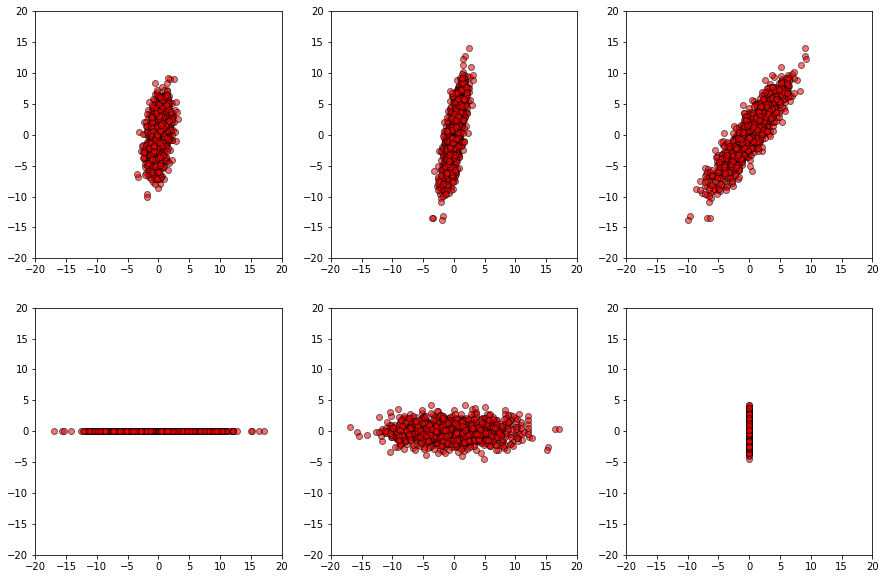

In [5]:
#Redefine the data in the basis yielded by the PCA procedure

new_data = pd.DataFrame(np.dot(V.T , dataset))

#Plot the data points in the original and the new coordiantes as a set of scatter plots. 
#Your final figure should have 2 rows of 3 plots each,
#where the columns show the (0,1), (0,2) and (1,2) proejctions.

fig , ((ax1,ax2,ax3) , (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

ax1.scatter(dataset.loc[0,:] , dataset.loc[1,:], alpha=0.55 , c='red', edgecolors='black')
ax1.set_xlim([-20,20])
ax1.set_ylim([-20,20])

ax2.scatter(dataset.loc[0,:] , dataset.loc[2,:], alpha=0.55, c='red', edgecolors='black')
ax2.set_xlim([-20,20])
ax2.set_ylim([-20,20])

ax3.scatter(dataset.loc[1,:] , dataset.loc[2,:], alpha=0.55, c='red', edgecolors='black')
ax3.set_xlim([-20,20])
ax3.set_ylim([-20,20])

ax4.scatter(new_data.loc[0,:] , new_data.loc[1,:], alpha=0.55, c='red', edgecolors='black')
ax4.set_xlim([-20,20])
ax4.set_ylim([-20,20])

ax5.scatter(new_data.loc[0,:] , new_data.loc[2,:], alpha=0.55, c='red', edgecolors='black')
ax5.set_xlim([-20,20])
ax5.set_ylim([-20,20])

ax6.scatter(new_data.loc[1,:] , new_data.loc[2,:], alpha=0.55, c='red', edgecolors='black')
ax6.set_xlim([-20,20])
ax6.set_ylim([-20,20])



2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [6]:
noise = []

for i in range(10):
    noise.append(np.random.normal(0, 1/53 , N))
       
data2 = dataset.append(noise, ignore_index=True)

data2


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,-0.539231,0.551576,1.216752,-1.873041,0.009171,0.835156,1.173688,-0.586107,1.159273,0.216600,...,-1.087479,-0.408188,-0.785460,-0.739921,-0.269713,0.212419,-0.109282,1.447287,0.315547,0.293987
1,0.778945,-0.429098,1.928366,-3.466782,-0.755591,0.909521,6.550892,8.300933,-3.808332,0.042756,...,-3.941448,3.549515,-2.666324,-1.832346,7.252034,-3.639988,-1.120124,-0.552162,-1.361530,0.633493
2,-0.299518,0.674055,4.361870,-7.212864,-0.737249,2.579833,8.898269,7.128720,-1.489786,0.475955,...,-6.116405,2.733140,-4.237245,-3.312188,6.712607,-3.215149,-1.338688,2.342412,-0.730436,1.221467
3,0.016742,-0.013173,0.006731,-0.041474,0.008141,0.008127,0.007051,0.013970,0.020345,-0.010940,...,-0.027891,0.039449,-0.015692,0.021657,-0.002469,0.021414,-0.001987,-0.019386,-0.021591,-0.040308
4,-0.034677,0.011821,0.014232,-0.022758,0.006042,-0.017747,0.006154,-0.015138,0.027110,-0.043976,...,0.010764,0.007418,0.043671,0.047447,0.001974,-0.012650,0.007238,0.014519,-0.023368,0.001109
5,0.016219,-0.007122,0.031101,0.000088,-0.046905,0.005363,-0.007250,-0.031697,-0.018062,-0.045933,...,-0.006438,-0.004894,0.007142,-0.009693,-0.001982,-0.020268,-0.016173,-0.032877,-0.015996,0.007228
6,0.002058,-0.005824,0.012067,-0.012953,-0.023356,0.000208,-0.011721,-0.009223,0.016713,0.001336,...,0.003071,0.018379,-0.018964,-0.001661,0.003810,0.008616,0.010576,-0.003916,-0.001414,0.006282
7,-0.002937,0.015132,-0.006902,-0.002421,0.027729,0.039178,-0.019884,0.002312,0.011978,-0.008597,...,0.030612,-0.015858,-0.011005,-0.006304,0.007474,0.007606,0.001392,0.003264,0.080884,-0.006556
8,-0.008596,-0.022317,-0.025475,-0.013127,0.014563,0.031592,0.050942,-0.001010,0.011373,0.014334,...,-0.037459,-0.000658,-0.007665,-0.002994,0.008173,0.022495,-0.010066,0.031946,-0.000690,-0.046638
9,0.014934,0.023818,0.033037,-0.007312,-0.000655,-0.004307,-0.036465,0.005181,0.012554,0.020811,...,0.004342,0.010253,-0.016143,0.011511,0.011551,-0.013886,-0.019423,0.010732,-0.010946,0.017351


In [19]:
l2, V2 = la.eig(np.cov(data2))

Lambda2 = np.diag(np.real_if_close(l2))

print("\nVariability conserved component by component: \n", np.real_if_close(l2)/np.trace(Lambda2))

print ("\nPCA  k=2 (0,1):", abs(Lambda2[0,0] + Lambda2[1,1] )/Lambda2.trace(), "of the dataset's variability conserved")

print("\nThe two principal variables are the first and the second ones.")
print("Variability of the noise is neglectable; being uncorrelated it has less meaning in the analysis")


Variability conserved component by component: 
 [9.36115213e-01 6.37636936e-02 2.91064904e-17 1.47140204e-05
 1.38870615e-05 1.32719979e-05 1.03071759e-05 1.06039997e-05
 1.07331099e-05 1.23567189e-05 1.22279187e-05 1.14047943e-05
 1.15861796e-05]

PCA  k=2 (0,1): 0.9998789070230945 of the dataset's variability conserved

The two principal variables are the first and the second ones.
Variability of the noise is neglectable; being uncorrelated it has less meaning in the analysis


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


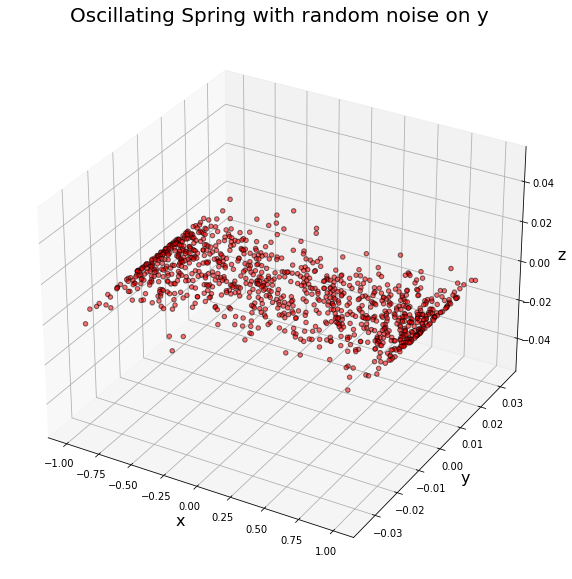

In [8]:
n = 1001

t0=0
dt=0.1
#omega=1

x=[np.cos(t0+dt*i) for i in range(n)]

y=np.random.normal(0, 0.01 , n)  #y0 setted = 0

z=np.zeros(n)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z , alpha=0.55, c='red', edgecolors='black')
ax.set_title("Oscillating Spring with random noise on y" , fontsize=20)
ax.set_xlabel("x" , fontsize=16)
ax.set_ylabel("y", fontsize=16)
ax.set_zlabel("z", fontsize=16)
plt.show()

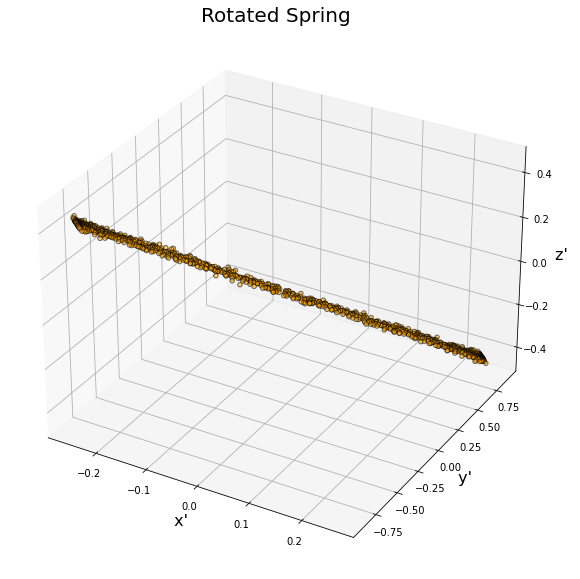

In [9]:
def camera(theta,phi):
    
    rot_y = np.array( [ [np.cos(theta) , 0 , np.sin(theta)] , [0 , 1 , 0] , [-np.sin(theta), 0 , np.cos(theta) ]])
    rot_z = np.array( [ [np.cos(phi) , -np.sin(phi) , 0] , [np.sin(phi) , np.cos(phi) , 0] , [0, 0 , 1] ])
    
    return rot_y.dot(rot_z)



#example of rotation

rotation = camera(np.pi/3 , np.pi/3).dot(np.array([x,y,z]))

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(rotation[0], rotation[1], rotation[2] , alpha=0.55, c='orange', edgecolors='black')

ax.set_title("Rotated Spring " , fontsize=20)
ax.set_xlabel(" x' " , fontsize=16)
ax.set_ylabel(" y' ", fontsize=16)
ax.set_zlabel(" z' ", fontsize=16)

plt.show()

In [10]:
#building dataset

in_pos=np.array([x,y,z])

n_cameras=11

theta_rot= np.random.uniform(0 , np.pi, n_cameras)
phi_rot= np.random.uniform(0, 2*np.pi , n_cameras)

views=[]
for t, p in zip(theta_rot , phi_rot):
    views.append( camera(t,p).dot(in_pos) )

dataset_list = ([x,y,z])

for v in views:
    for i in range(3):
        dataset_list.append(v[i])

dataset_spring=pd.DataFrame(dataset_list)
    
    
#performing PCA    
lr, Vr = la.eig(np.cov(dataset_spring))

LambdaR = np.diag(np.real_if_close(lr))

print("\nVariability conserved component by component: \n \n", np.real_if_close(lr)/np.trace(LambdaR))


Variability conserved component by component: 
 
 [ 9.99783334e-01  2.16666484e-04 -8.57899402e-17  8.74939405e-17
 -7.93734743e-17  6.61728224e-17  5.28795150e-17 -5.49360356e-17
  4.61154572e-17 -4.95968696e-17 -4.69670602e-17  4.12063207e-17
 -4.03218476e-17  3.39816308e-17 -8.19993598e-20 -8.19993598e-20
  2.34584530e-17  1.88740201e-17 -2.11280957e-17 -1.42643850e-17
 -1.42643850e-17 -1.49369633e-17  1.07664948e-17 -1.02635532e-17
 -7.52691314e-18  9.22517029e-18  6.49779862e-18 -4.44888627e-18
 -3.04895008e-18  3.78864672e-18 -1.02070461e-18  1.94015109e-18
  1.34842716e-18 -5.59239344e-21  6.88236601e-20  0.00000000e+00]


To cover more than the 90% of the dataset's variability the first component is enough. 
In fact, as the simulation is generated, the most important component (the one that is the most meaningful for the analysis) is the first one, i.e. the one that contains the view of the x axis. 

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [11]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P /home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs7/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P /home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs7/

--2021-12-11 15:46:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 1477391 (1,4M) [application/x-httpd-php]
Salvataggio in: «/home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs7/magic04.data.1»

magic04.data.1      100%[===================>]   1,41M   151KB/s    in 6,8s    

2021-12-11 15:46:26 (213 KB/s) - «/home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs7/magic04.data.1» salvato [1477391/1477391]

--2021-12-11 15:46:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 

In [12]:
file_name='/home/ilazza/LaboratoryOfComputationalPhysics_Y4/dataEs7/magic04.data'
dataf=pd.read_csv( file_name, index_col=False)

labels=['fLength' ,'fWidth' , 'fSize', 'fConc', 'fConc1' , 'fAsym' , 'fM3Long', 'fM3Trans' , 'fAlpha', 'fDist', 'class']

dataf.columns = labels

dataf

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [13]:
#reading magic.name , class h is background

dataf = dataf[dataf['class'] == "g"]
dataf = dataf.drop(['class'] , axis=1)


#reshaping and doing things to perform PCA

dataset=dataf.to_numpy()
dataset = dataset.reshape((dataset.shape[1], dataset.shape[0]))

dataset

array([[ 3.16036e+01,  1.17235e+01,  2.51850e+00, ...,  1.96670e+00,
         2.86609e+02,  4.88751e+01],
       [ 1.94472e+01,  3.06430e+00,  2.45800e-01, ...,  4.24215e+02,
         1.24992e+01,  1.19681e+01],
       [ 2.03940e+00,  6.94100e-01,  3.51600e-01, ...,  2.27090e+01,
         4.30000e-03,  2.20280e+00],
       ...,
       [ 1.21093e+01,  8.17696e+01,  1.12872e+02, ...,  2.82344e+01,
         3.30502e+01,  7.50990e+00],
       [ 6.61000e+00,  2.35973e+02,  3.19610e+01, ..., -1.99657e+01,
         1.17531e+01,  2.28802e+01],
       [ 1.26280e+02,  2.45973e+01,  1.52460e+01, ..., -1.20726e+01,
         1.75809e+01,  1.71227e+02]])

In [14]:
#performing PCA   

lmagic, Vmagic = la.eig(np.cov(dataset[:,:1000]))

LambdaMagic = np.diag(np.real_if_close(lmagic))
sortedL_magic= - np.sort( - np.real_if_close(lmagic))


PCA = sortedL_magic/np.trace(LambdaMagic)
print("\n PCA Variability conserved component by component: \n \n", PCA)
print('\n ')
variability = 0

for k in range(1, len(PCA)+1):
    
    variability = PCA[:k].sum()
    
    if variability > 0.9 :
        print("PCA works good and can reduce from " , len(PCA) , " to k = ", k, " components , with a variability of", variability)
        break
        
    elif k == len(PCA)-1:
        print("PCA failed, max variability reached is ", variability, "with", k, "components of", len(PCA))




 PCA Variability conserved component by component: 
 
 [0.16645484 0.16515049 0.11828735 0.10941359 0.09769913 0.09561794
 0.08052453 0.07916915 0.06578007 0.0219029 ]

 
PCA works good and can reduce from  10  to k =  8  components , with a variability of 0.9123170293841735
